In [61]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count
import time
from random import randint

import cProfile
from datetime import datetime
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10,10)
legend_fontsize = 16

from matplotlib import rc

plt.ion()
# rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
# rc('figure', **{'dpi': 300})

In [62]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getState(), env.getEmptySpaces()
    if pi.name != 'Random' and pi.Q(s) != []:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q(s)[i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi.name != 'Random' and pi.Q(s) != []:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q(s)[i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, verbose=True, fontq=20, fontx=60):
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi.name != 'Random'):
        if pi.Q(s) != []:
            for i,a in enumerate(s[1]):
                print(i, a, pi.Q(s)[i])
        else:
            print("LALALA")
    return pi.forward(s)

def plot_test_game(env, pi1, pi2, verbose=False, fontq=20, fontx=20):
    done = False
    env.reset()
    while not done:
        s = env.getState()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, verbose=verbose, fontq=fontq, fontx=fontx)
        a = env.action_from_int(a)
        observation, reward, done, info = env.step(a)
        if reward == 1:
            plot_board(env, pi1, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            plot_board(env, pi2, showtext=False, fontq=fontq, fontx=fontx)

# Q learning

In [73]:
class QTabularAgent:
    def __init__(self, gamma=0.1, lr=0.01, epsilon=0.3):
        self.Q_ = dict()
        self.policy = dict()
        self.train_ = True
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.name = 'QTabular'
        self.history = []
        
    def Q(self, state):
        return Q_[state] if state in Q_ else []
        
    def eval(self):
        self.train_ = False
        
    def train(self):
        self.train_ = True
        
    def hash_state_(self, state):
        return (state[0], state[2])
        
    def forward(self, state):
        actions_num = len(state[1])
        state = self.hash_state_(state)
        if not state in self.Q_:
            self.Q_[state] = np.zeros(actions_num)
            self.policy[state] = randint(0, self.Q_[state].shape[0] - 1)
        if not self.train_:
            return self.policy[state]
        action = self.policy[state] if np.random.random() < self.epsilon else randint(0, self.Q_[state].shape[0] - 1)
        if self.train_:
            self.history.append((state, action))
        return action
    
    def backward(self, reward):
        state = self.history[-1][0]
        action = self.history[-1][1]
        self.Q_[state][action] += self.lr * (reward * (1 + self.gamma) - self.Q_[state][action])
        self.policy[state] = np.argmax(self.Q_[state])   
        for i in range(len(self.history) - 2, -1, -1):
            state = self.history[i][0]
            action = self.history[i][1]
            next_state = self.history[i + 1][0]
            self.Q_[state][action] += self.lr * (reward + self.gamma * np.max(self.Q_[next_state]) - self.Q_[state][action])
            self.policy[state] = np.argmax(self.Q_[state])   
        self.history = []
      

In [74]:
class RandomAgent:
    def __init__(self, env):
        self.name = 'Random'
        self.env = env
    
    def eval(self):
        pass
    
    def train(self):
        pass
    
    def forward(self, state):
        action_idx = randint(0, state[1].shape[0] - 1)
        return action_idx
#         return self.env.int_from_action(state[1][action_idx])
    
    def backward(self, reward):
        pass

In [75]:
class DynamicPlot:
    def __init__(self):
        self.plots = {}
        self.fig = None
        
    def update(self, name, data_x, data_y):
        if name in self.plots:
            self.plots[name][0].append(data_x) 
            self.plots[name][1].append(data_y)
        else:
            self.plots[name] = [[data_x], [data_y]]
            
    def draw(self):
        if self.fig:
            self.fig.clear()
        else:
            self.fig = plt.figure(figsize=(10,10))
        n_plots = len(set(name.split('_')[0] for name in self.plots))
        groups = {}
        for name in self.plots:
            prefix = name.split('_')[0]
            suffix = name.split('_')[1]
            if not prefix in groups:
                groups[prefix] = {'ax': self.fig.add_subplot(n_plots, 1, len(groups) + 1)}
            groups[prefix]['ax'].plot(self.plots[name][0], self.plots[name][1], label = suffix)
            groups[prefix]['ax'].set_title(prefix, loc='right')
            groups[prefix]['ax'].legend()
        
        plt.subplots_adjust(hspace=0.5)
        self.fig.canvas.draw()
                

In [76]:
def train(env, x_agent, o_agent, num_episodes=100000, log_del=100):
    dynamic_plot = DynamicPlot()
    steps = range(0, num_episodes, num_episodes // log_del)
    players = {1: x_agent, -1: o_agent}
    x_agent.train()
    o_agent.train()
    for episode in tqdm(range(num_episodes)):
        env.reset()
        state  = env.getState()
        done = False
        while not done:
            action = players[state[2]].forward(state)
#             if players[state[2]].name == 'QTabular':
#                 print('state: {}'.format(state))
#                 print('Q[state]: {}'.format(players[state[2]].Q[x_agent.hash_state_(state)]))
#                 print('action: {}'.format(action))
            next_state, reward, done, info = env.step(state[1][action])
            if done:
                x_agent.backward(reward)
                o_agent.backward(-reward)
            state = next_state
        
        if episode % (num_episodes//100) == 0:
            x_agent.eval()
            o_agent.eval()
            win_x, win_o, draw = test(env, x_agent, o_agent, num_tests=100)
            x_agent.train()
            o_agent.train()
            dynamic_plot.update('Learn board_{}(X):win'.format(x_agent.name), episode, win_x)
            dynamic_plot.update('Learn board_{}(O):win'.format(o_agent.name), episode, win_o)
            dynamic_plot.update('Learn board_draw', episode, draw)
            dynamic_plot.draw()
            
def test(env, x_agent, o_agent, num_tests=100):
    win_x = 0
    win_o = 0
    draw = 0
    players = {1: x_agent, -1: o_agent}
    for _ in range(num_tests):
        done = False
        env.reset()
        state = env.getState()
        reward = -10
        while not done:
#             print('test state: ', state)
            action = players[state[2]].forward(state)
#             print('test palyer:', state[2])
#             print('test action: ', action)
            next_state, reward, done, info = env.step(state[1][action])
#             print('test reward: ', reward)
            if done:
                break
            state = next_state
        if reward == -10:
            raise('Error state')
        elif reward == 0:
            draw += 1
        elif reward == 1:
            win_x += 1
        elif reward == -1:
            win_o += 1
    return win_x / num_tests, win_o / num_tests, draw / num_tests

<IPython.core.display.Javascript object>


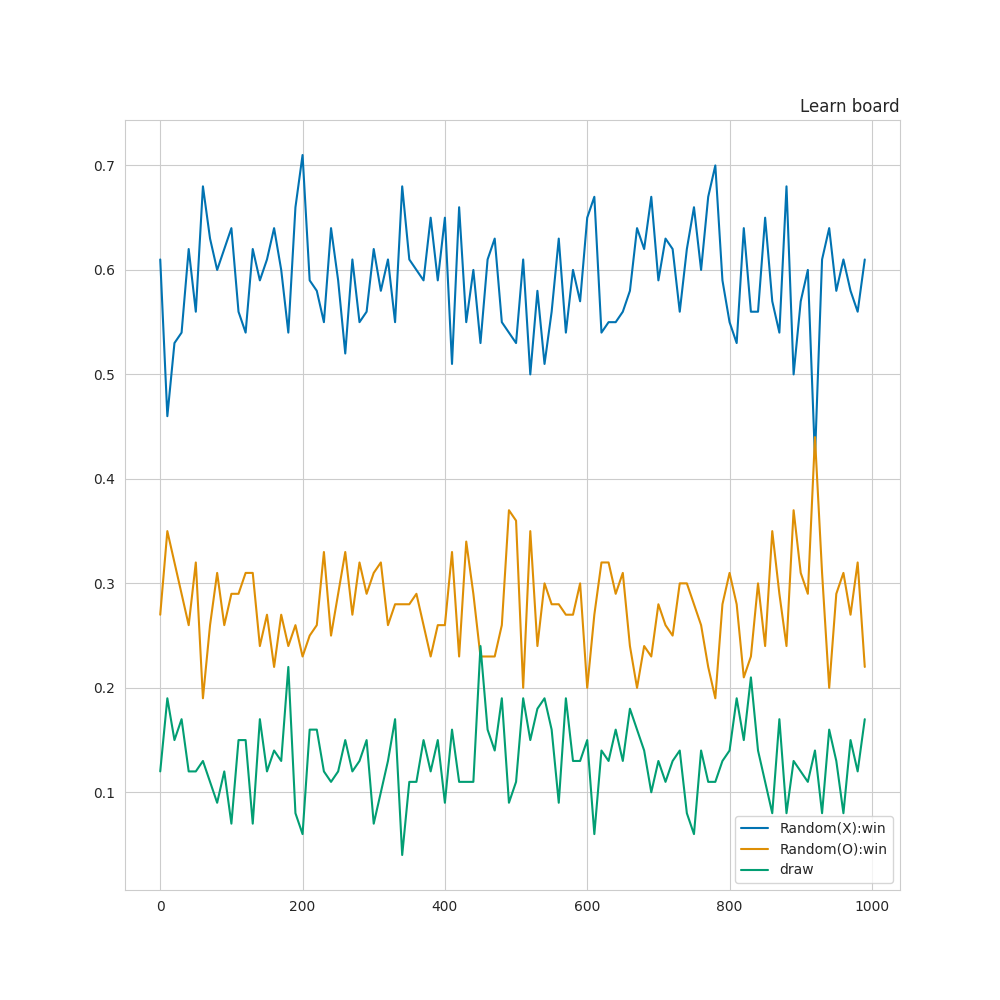

In [78]:
%matplotlib notebook

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

x_agent = RandomAgent(env)
o_agent = RandomAgent(env)
train(env, x_agent, o_agent, num_episodes=1000)

<IPython.core.display.Javascript object>


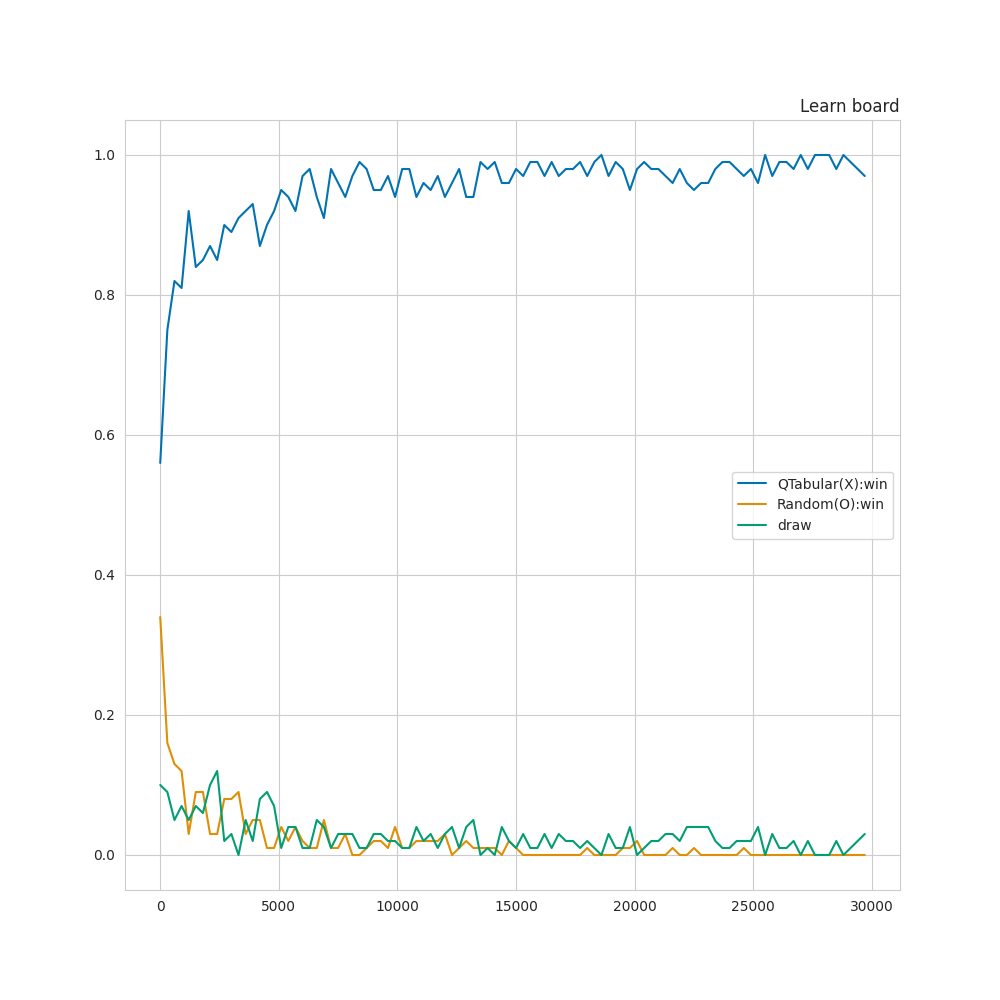

In [82]:
%matplotlib notebook

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

x_agent = QTabularAgent(gamma=1, lr=0.01, epsilon=0.3)
o_agent = RandomAgent(env)
train(env, x_agent, o_agent, num_episodes=30000)

<IPython.core.display.Javascript object>


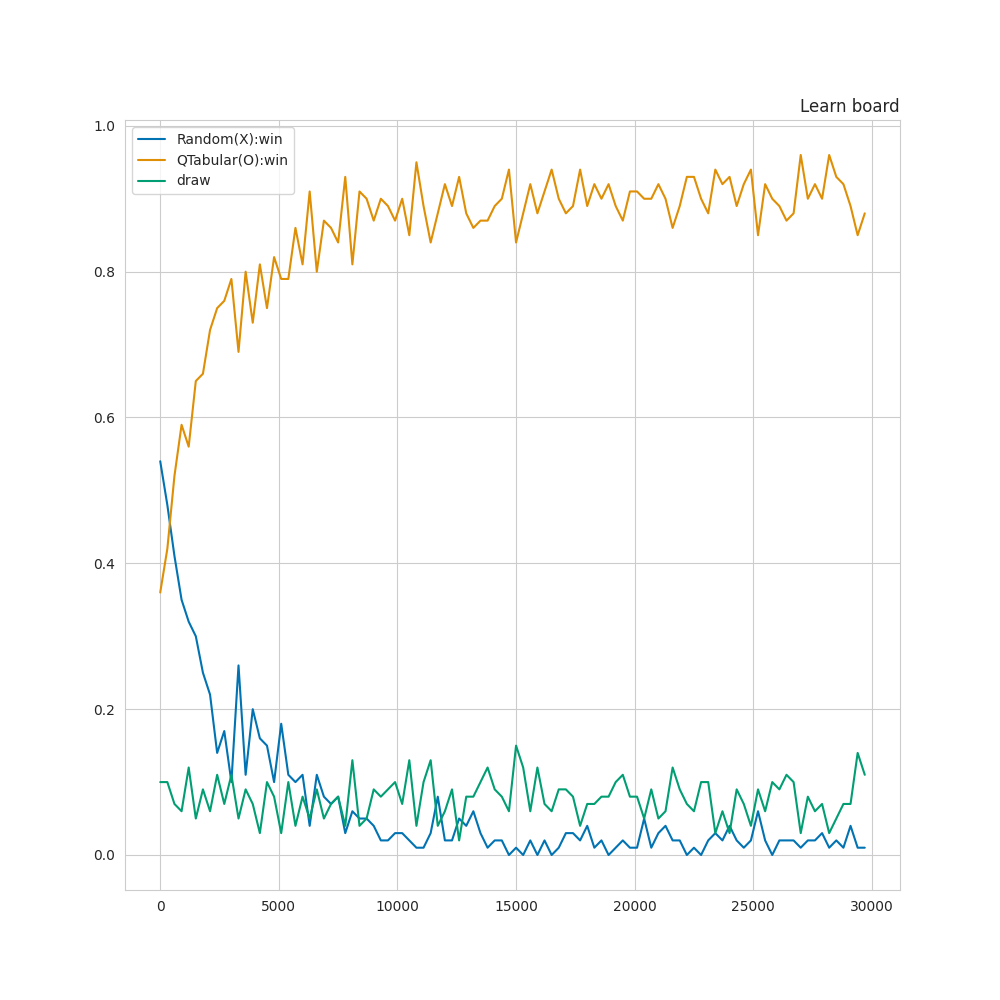

In [83]:
%matplotlib notebook

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

x_agent = RandomAgent(env)
o_agent = QTabularAgent(gamma=1, lr=0.01, epsilon=0.3)
train(env, x_agent, o_agent, num_episodes=30000)

<IPython.core.display.Javascript object>


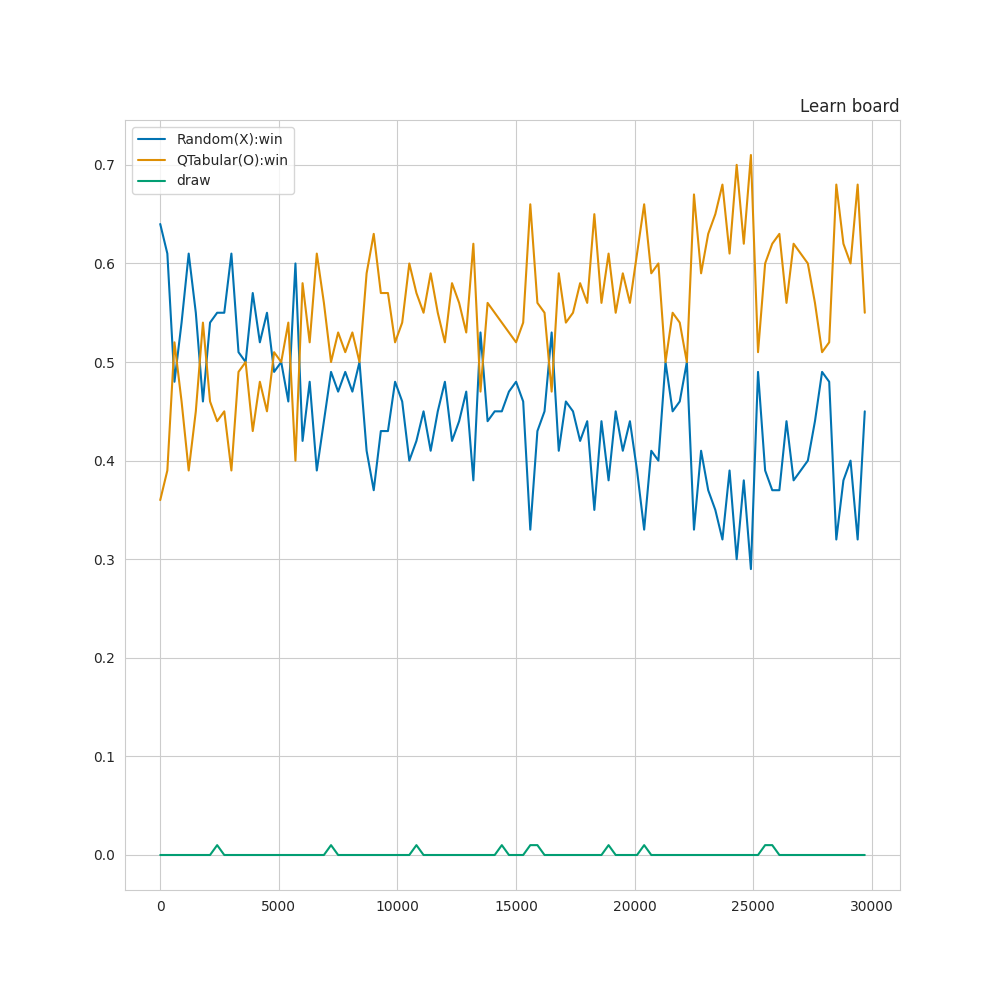

In [84]:
%matplotlib notebook

env = TicTacToe(n_rows=4, n_cols=4, n_win=3)

x_agent = RandomAgent(env)
o_agent = QTabularAgent(gamma=1, lr=0.01, epsilon=0.3)
train(env, x_agent, o_agent, num_episodes=30000)

<IPython.core.display.Javascript object>


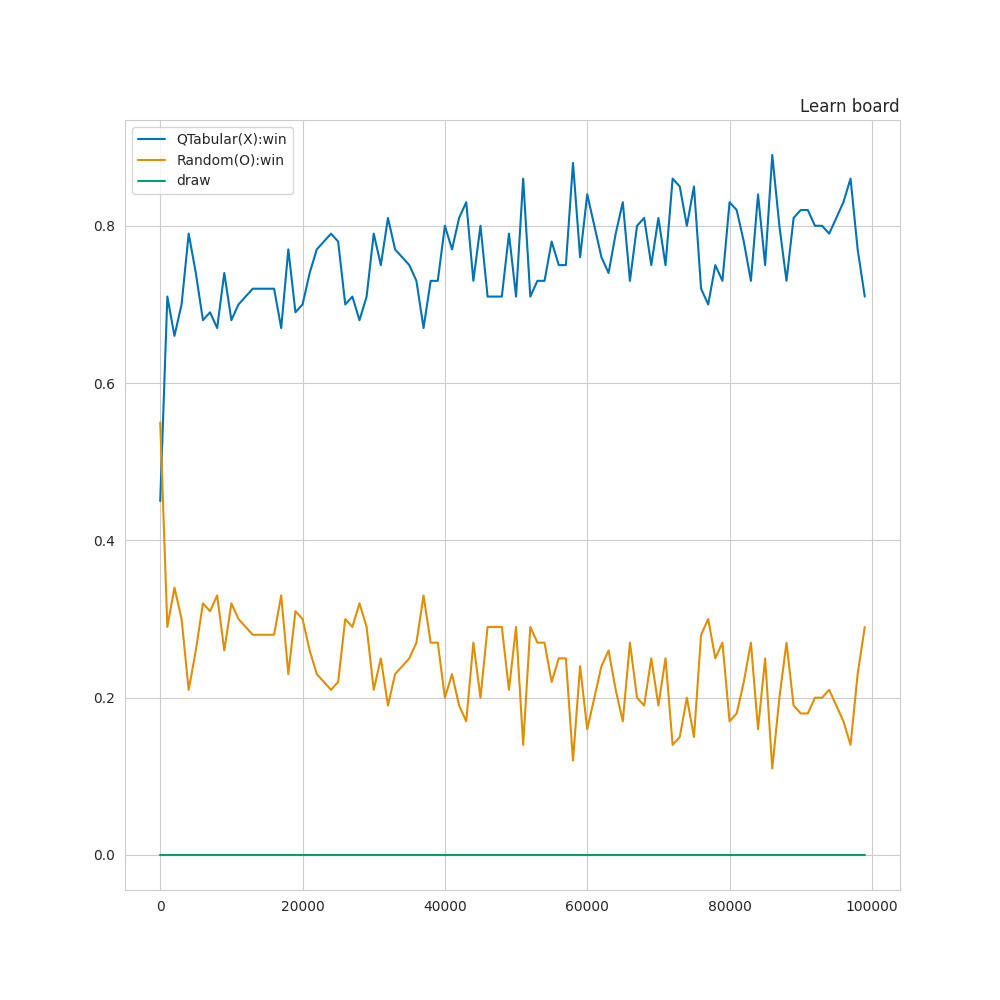

In [86]:
%matplotlib notebook

env = TicTacToe(n_rows=5, n_cols=5, n_win=3)

x_agent = QTabularAgent(gamma=1, lr=0.01, epsilon=0.3)
o_agent = RandomAgent(env)
train(env, x_agent, o_agent, num_episodes=100000)

# DQN (+Double)

### Utils

In [7]:
class PrioritizedReplayBuffer:
#     Взято из https://github.com/abstractpaper/prop/blob/master/prop/buffers/priority_replay_buffer.py
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment_per_sampling=0.001, e=0.01):
        self.tree = SumTree(capacity)
        self.alpha = alpha # (0 - no prioritization, 1 - full prioritization)
        self.beta = beta   # importance sampling; increase to 1 over time
        self.beta_increment_per_sampling = beta_increment_per_sampling
        self.e = e

    def _get_priority(self, error):
        # (td error + epsilon) ^ alpha
        return (np.abs(error) + self.e) ** self.alpha

    def push(self, error, transition):
        p = self._get_priority(error)
        self.tree.add(p, transition)

    def sample(self, batch_size):
        batch = []
        idxs = []
        segment = self.tree.total / batch_size
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)

    def __len__(self):
        return self.tree.n_entries

# Значение любой вершины дерева - сумма значений его 'детей'
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # обновляем дерев
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # находи вершину (бинарный поиск)
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    @property
    def total(self):
        return self.tree[0]

    # добавляем элемент в дерево
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # обновляем вершины дерева
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # находим приоритет и вершину
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'mask'))

In [8]:
import numpy as np
from random import choice
import math

class DQNAgent:
    def __init__(
        self,
        model,
        buffer_capacity=10000,
        batch_size=32,
        gamma=0.99,
        lr_base=0.1,
        eps=0.9,
        device='cpu',
        double=False,
        agent_side=1
    ):
        self.model = model.to(device)
        self.model_target = model.to(device)
        self.buffer = PrioritizedReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr_base = lr_base
        self.lr = lr_base
        self.train_ = True
        self.action_n = None
        self.eps = 0.9
        self.device = device
        self.double=double
        self.optimizer = optim.Adam(params=self.model.parameters(), lr=lr_base)
        self.plot = DynamicPlot()
        self.agent_side = agent_side
        self.opponent = None
        self.name = 'DQNAgent'

    @torch.no_grad()
    def Q(self, state):
        legal_actions_idx = torch.from_numpy(np.array([self.env.int_from_action(_) for _ in state[1]]))
        tensor = self.state2tensor_(state).to(self.device)
#         print(tensor)
        output = self.model(tensor)
#         print(output)
#         print('============')
        return output[0][legal_actions_idx].cpu().numpy()
        
    def train(self):
        self.model.train()
        self.train_ = True
        
    def eval(self):
        self.model.eval()
        self.train_ = False
      
    @torch.no_grad()
    def forward(self, state):
        legal_actions_idx = torch.from_numpy(np.array([self.env.int_from_action(_) for _ in state[1]]))
        tensor = self.state2tensor_(state).to(self.device)
        output = self.model(tensor)[0][legal_actions_idx].argmax().cpu().numpy()
        return legal_actions_idx[output]
        
    def state2tensor_(self, state):
        state_ = state[0] # '1201201220...'
#         dim_ = int(np.sqrt(len(state_)))
        tensor = torch.tensor([int(_) for _ in state_])
        return tensor
     
    @torch.no_grad()    
    def step_(self, state, eps, actions_idx):
        if self.train_ and np.random.rand() < eps:
            return torch.tensor(choice(range(len(actions_idx))))
        tensor = self.state2tensor_(state).to(self.device)
#         if self.train_:
#             return self.model(tensor)[0][actions_idx].argmax()
        return self.model(tensor)[0][actions_idx].argmax()
        
    def play(self, env):
        env.reset()
        state = env.getState()
        reward = None
        while True:
            legal_actions_idx = torch.from_numpy(np.array([env.int_from_action(_) for _ in state[1]]))
            legal_actions_mask = torch.zeros(len(state[0]), dtype=torch.bool)
            legal_actions_mask[legal_actions_idx] = True
#             print('state:', state)
#             print('player:', state[2])
            if state[2] != self.agent_side:
                action = torch.tensor(self.opponent.forward(state))
            else:
                action = legal_actions_idx[self.step_(state, self.eps, legal_actions_idx).item()]
#             print('action:', action)
            next_state, reward, done, _ = env.step(env.action_from_int(action))
#             print('reward:', reward)
            if self.train_:
                transition = Transition(state, action, next_state if not done else None, self.agent_side * reward, legal_actions_mask)
                self.buffer.push(self.buffer.tree.total, transition)
            if done:
                break
            state = next_state 
        return self.agent_side * reward
            
    def learn(self, env, opponent, num_iter, freq_target_update, log_interval=100, start_iter=0):
        eps_decay = self.eps / num_iter
        eps = self.eps
        self.env = env
        self.opponent = opponent
        losses = []
        for iter_ in range(num_iter):
            self.eps -= eps_decay
            self.play(env)
            transitions, idxs, is_weights = self.buffer.sample(self.batch_size)
            if len(transitions) < self.batch_size:
                continue
            loss = self.optimize(transitions, idxs, is_weights).item()
            losses.append(loss)
            if iter_ % log_interval == 0:
                self.plot.update('Losses table_train loss', start_iter + iter_, loss)
                self.plot.update('Losses table_avg train loss', start_iter + iter_, np.mean(losses))
                self.plot.update('Eps table_eps', start_iter + iter_, self.eps)
                self.eval()
                agent_x = self if self.agent_side == 1 else self.opponent
                agent_o = self if self.agent_side == -1 else self.opponent
                win_x, win_o, draw = test(env, agent_x, agent_o)
                self.plot.update('Learn board_{}(X):win'.format(agent_x.name), iter_, win_x)
                self.plot.update('Learn board_{}(O):win'.format(agent_o.name), iter_, win_o)
                self.plot.update('Learn board_draw', iter_, draw)
                self.plot.draw()
                self.train()
            if iter_ % freq_target_update == 0:
                self.model_target.load_state_dict(self.model.state_dict())
#             break
        self.eps = eps
            
            
    def optimize(self, transitions, idxs, is_weights):
#         print(transitions)
        self.optimizer.zero_grad()
        batch = Transition(*zip(*transitions))
        state_batch = torch.stack([self.state2tensor_(_) for _ in batch.state]).to(self.device)
        mask_batch = torch.stack(batch.mask).to(self.device)
        action_batch = torch.Tensor(batch.action).to(self.device)
#         print('batch.state:', batch.state)
#         print('state_batch:', state_batch)
#         print('batch.mask:', batch.mask)
#         print('mask_batch:', mask_batch)
#         print('batch.action:', batch.action)
#         print('action_batch:', action_batch)
        output = self.model(state_batch)
        output[~mask_batch] = - math.inf
#         print('output1:', output)
        output = output.gather(1, action_batch.unsqueeze(1).long())
#         print('output2:', output)
        target = self.target(batch)
        batch_loss = F.smooth_l1_loss(output, target, reduction='none')
#         loss = (sum(batch_loss * torch.FloatTensor(is_weights).to(self.device).unsqueeze(1))/self.batch_size).squeeze()
        loss = (sum(batch_loss)/self.batch_size).squeeze()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        for i in range(self.batch_size):
            self.buffer.update(idxs[i], batch_loss[i].item())
        for param in self.model.parameters():
            # клипаем крадиенты
            param.grad.data.clamp_(-1, 1)
#         raise ValueErrore
        return loss
            
            
    def target(self, batch):
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.stack([self.state2tensor_(s) for s in batch.next_state if s is not None]).to(self.device)
        next_mask = torch.stack([i for (i, v) in zip(list(batch.mask), non_final_mask.tolist()) if v]).to(self.device)
        next_state_values = torch.zeros(self.batch_size).to(self.device)
        if len(non_final_next_states) > 0:
            if self.double:
                next_state_actions = self.model(non_final_next_states)
                next_state_actions[~next_mask] = - math.inf
                next_state_actions = next_state_actions.argmax(1).unsqueeze(-1)
                target_values = self.model_target(non_final_next_states)
                target_values[~next_mask] = - math.inf
                next_state_values[non_final_mask] = target_values.gather(1, next_state_actions).squeeze(-1)
            else:
                target_values = self.model_target(non_final_next_states)
                target_values[~next_mask] = - math.inf
                next_state_values[non_final_mask] = target_values.max(1)[0].detach()
            
        reward_batch = torch.Tensor([[r] for r in batch.reward]).to(self.device)
        state_action_values = reward_batch + (next_state_values.unsqueeze(1) * self.gamma)
        return state_action_values

### Network

In [9]:
class QCnn(nn.Module):
    def __init__(self, n_actions):
        super(QCnn, self).__init__()
        self.n_actions = n_actions
        self.dim = int(np.sqrt(n_actions))
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=512, kernel_size=3, stride=1, padding=2),
            nn.ReLU(), # negative numbers -> 0
            nn.MaxPool2d(kernel_size=self.dim + 2, stride=1), 
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, self.n_actions)
        )
        

    def forward(self, x):
        empty = torch.zeros(x.size(), device = x.device).masked_scatter_((x == 1), torch.ones(x.size(), device = x.device)).view(-1, self.dim, self.dim)
        player1 = torch.zeros(x.size(), device = x.device).masked_scatter_((x == 2), torch.ones(x.size(), device = x.device)).view(-1, self.dim, self.dim)
        player2 = torch.zeros(x.size(), device = x.device).masked_scatter_((x == 0), torch.ones(x.size(), device = x.device)).view(-1, self.dim, self.dim)
        cnn_input = torch.stack((empty, player1, player2), dim=1)
        actions = self.net(cnn_input)
        return actions

### DQN

In [10]:
env = TicTacToe(n_cols=3, n_rows=3, n_win=3)
model = QCnn(3 * 3)
agent = DQNAgent(model, double=False, agent_side=1, lr_base=0.0001, device='cuda:0', batch_size=128)
opponent=RandomAgent(env)

<IPython.core.display.Javascript object>


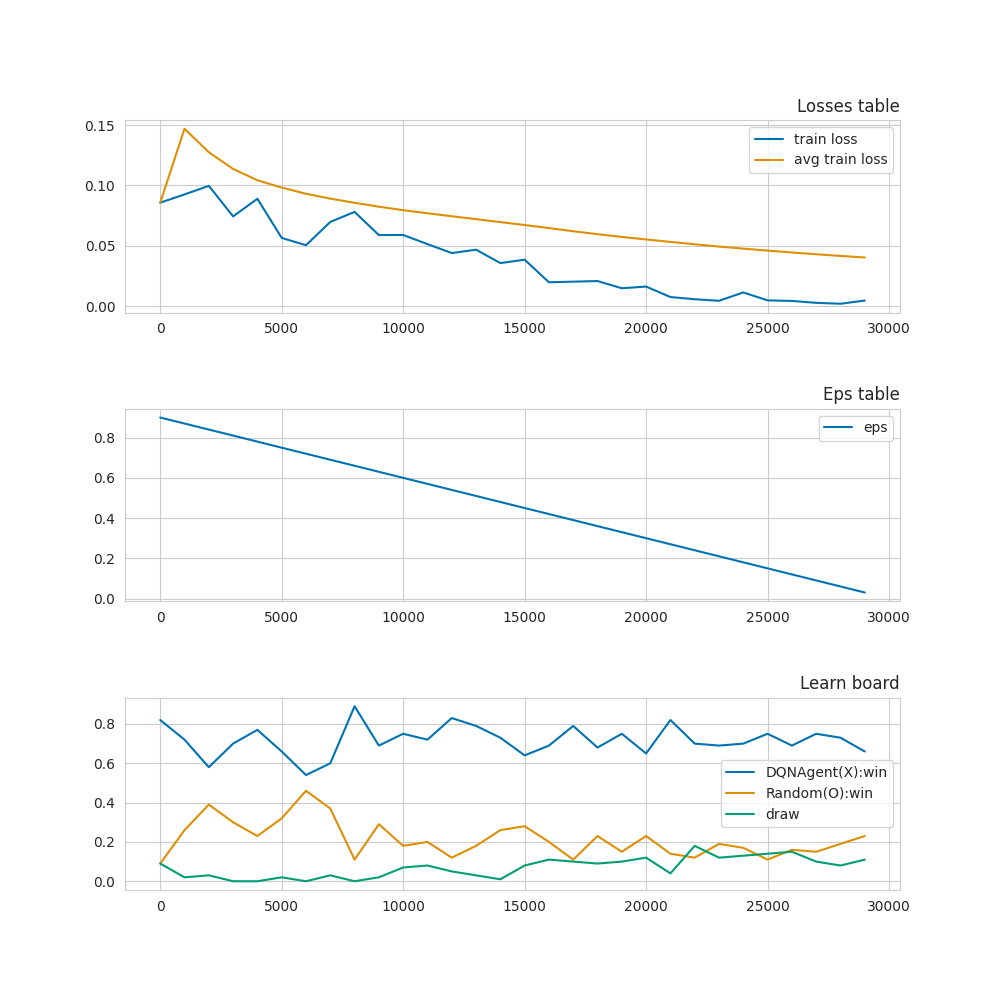

In [11]:
%matplotlib notebook
agent.train()
agent.learn(env, opponent, 30000, 5000, 1000, 0)


In [13]:
env = TicTacToe(n_cols=3, n_rows=3, n_win=3)
model = QCnn(3 * 3)
agent = DQNAgent(model, double=False, agent_side=-1, lr_base=0.0001, device='cuda:0', batch_size=128)
opponent=RandomAgent(env)

<IPython.core.display.Javascript object>


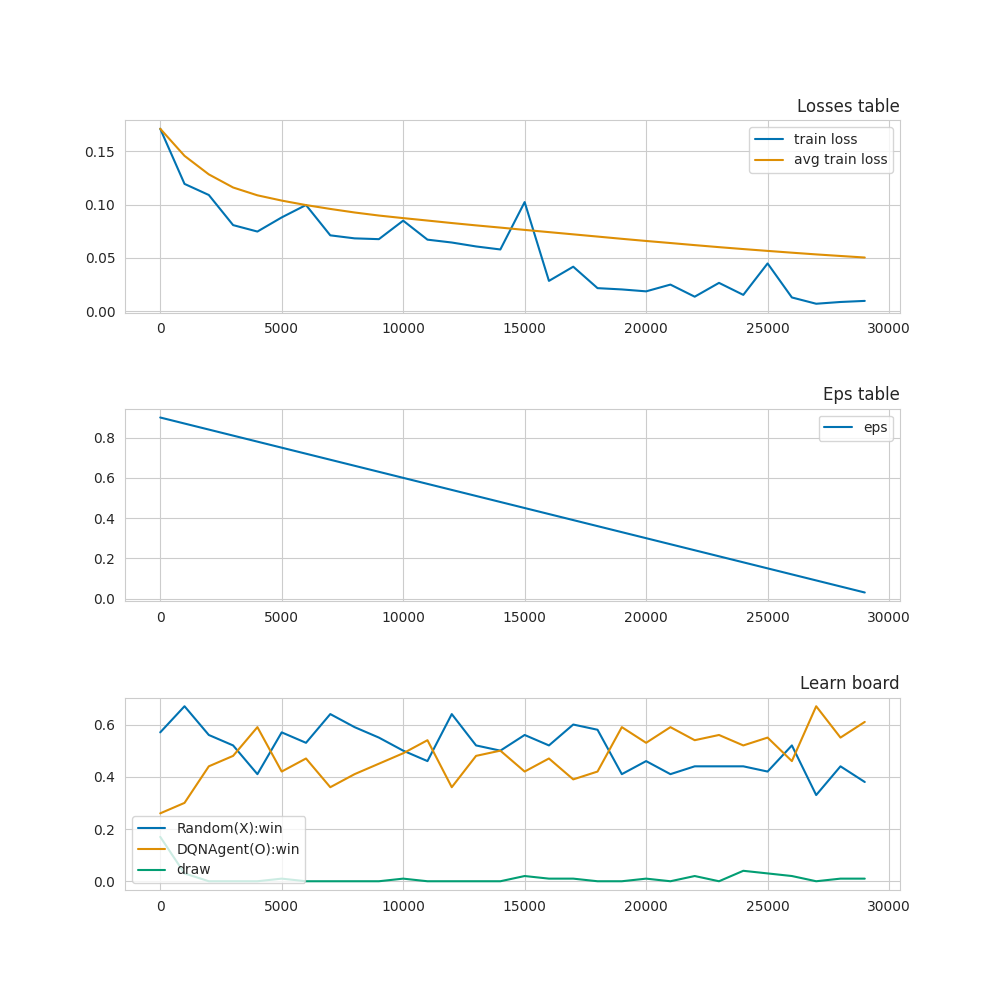

In [14]:
%matplotlib notebook
agent.train()
agent.learn(env, opponent, 30000, 5000, 1000, 0)


### Double DQN

In [20]:
env = TicTacToe(n_cols=3, n_rows=3, n_win=3)
model = QCnn(3 * 3)
agent = DQNAgent(model, double=True, agent_side=1, lr_base=0.0001, device='cuda:0', batch_size=64)
opponent=RandomAgent(env)

<IPython.core.display.Javascript object>


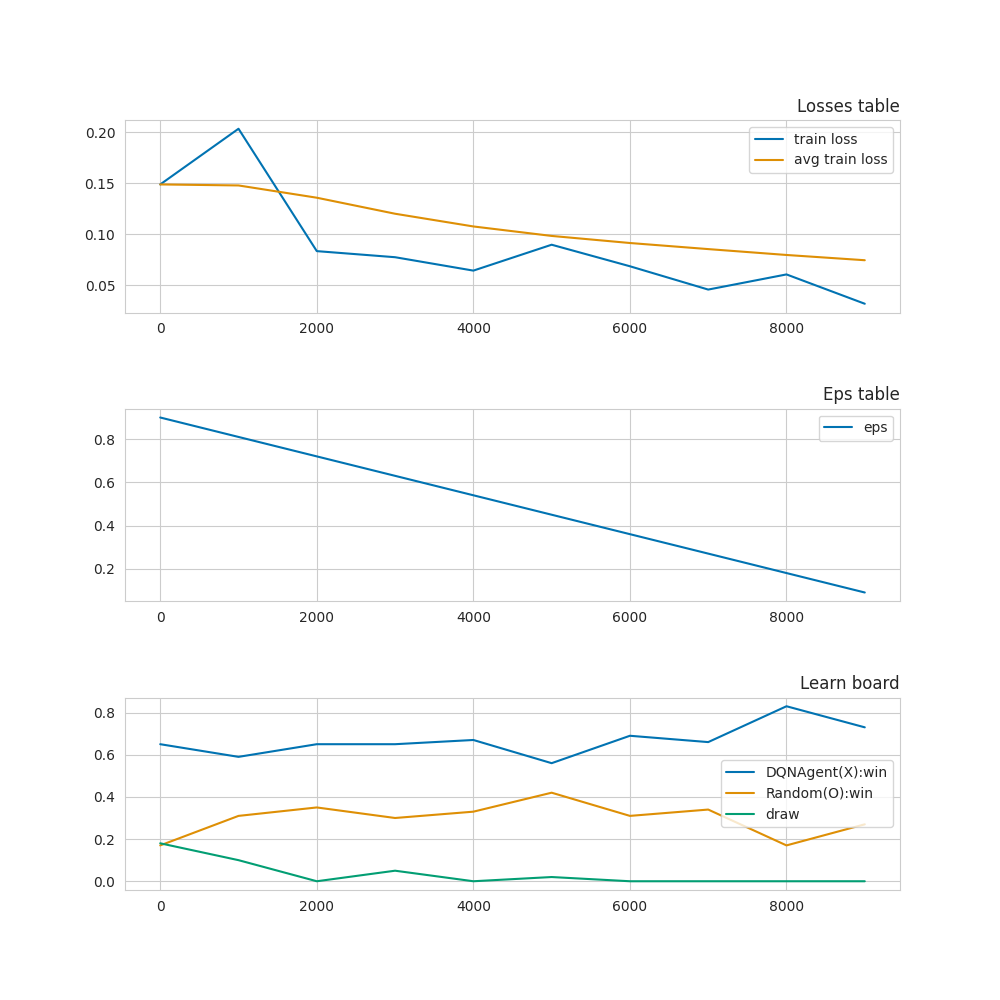

In [21]:
%matplotlib notebook
agent.train()
agent.learn(env, opponent, 10000, 1000, 1000, 0)

In [26]:
env = TicTacToe(n_cols=3, n_rows=3, n_win=3)
model = QCnn(3 * 3)
agent = DQNAgent(model, double=True, agent_side=-1, lr_base=0.00005, device='cuda:0', batch_size=32)
opponent=RandomAgent(env)

<IPython.core.display.Javascript object>


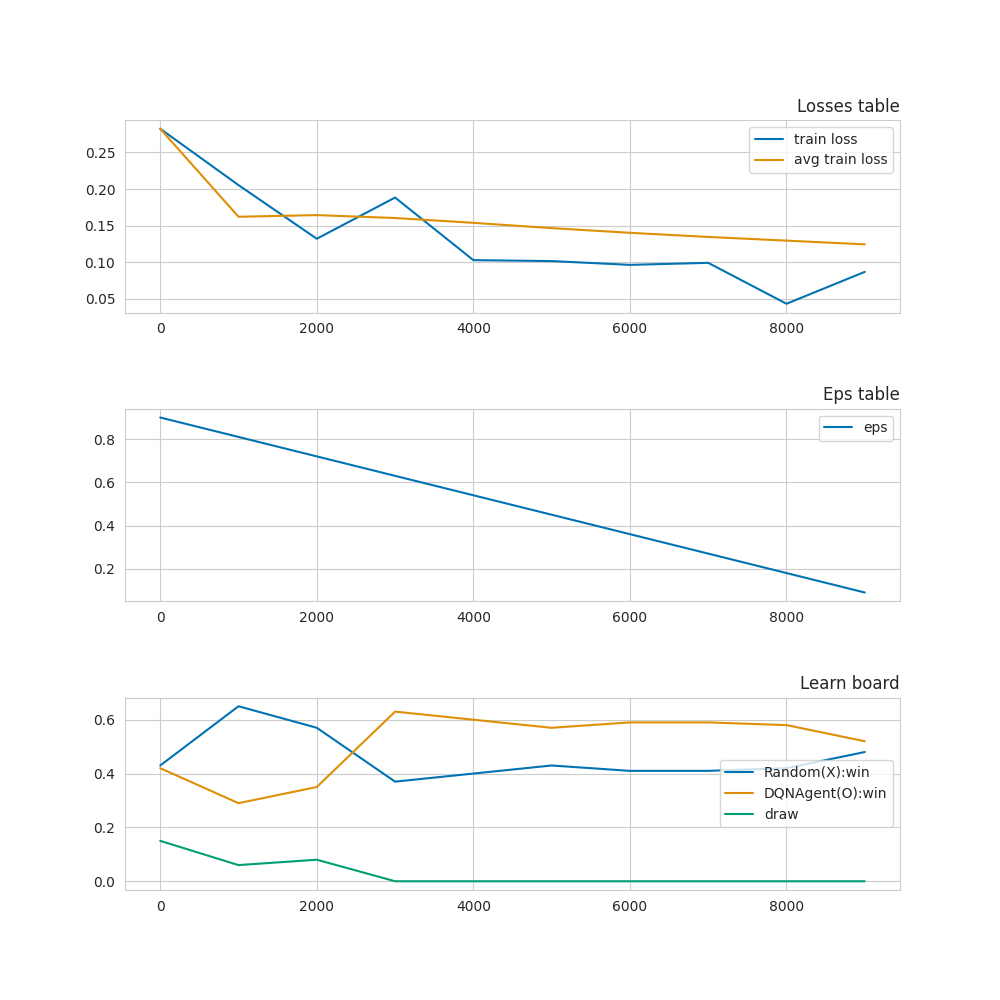

In [27]:
%matplotlib notebook
agent.train()
agent.learn(env, opponent, 10000, 2000, 1000, 0)

# MCTS

In [104]:
from collections import defaultdict
import math


N_ROWS = 3
N_COLS = 3
N_WINS = 3

class MCTS:
    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)
        self.N = defaultdict(int)
        self.children = dict() 
        self.exploration_weight = exploration_weight

    def choose(self, node):
        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return - math.inf
            return self.Q[n] / self.N[n] 

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)

    def _expand(self, node):
        if node in self.children:
            return 
        self.children[node] = node.find_children()

    def _simulate(self, node):
        invert_reward = True
        while True:
            if node.is_terminal():
                reward = node.reward()
                return 1 - reward if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward 

    def _uct_select(self, node):
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)
    
    
class TicTacToeNode(): 
    
    def __init__(self, state):
        self.state = state
    
    def find_children(self):
        state_, legal_actions, player = self.state
        dim = int(np.sqrt(len(state_)))
        childrens = set()
        symbol = '2' if player == 1 else '0'
        for idx, legal_action in enumerate(legal_actions):
            action_idx = dim * legal_action[0] + legal_action[1]
            new_state_ = state_[:action_idx] + symbol +  state_[action_idx + 1:]
            new_actions = [] if len(legal_actions) == 1 else np.concatenate((legal_actions[:idx], legal_actions[idx + 1:]))
            childrens.add(TicTacToeNode((new_state_, new_actions, player * -1)))
        return childrens
        

    def find_random_child(self):
        state_, legal_actions, player = self.state
        dim = int(np.sqrt(len(state_)))
        action_ = choice(range(len(legal_actions)))
        action = legal_actions[action_]
        action_idx = dim * action[0] + action[1]
        symbol = '2' if player == 1 else '0'
        new_state_ = state_[:action_idx] + symbol +  state_[action_idx + 1:]
        new_actions = [] if len(legal_actions) == 1 else np.concatenate((legal_actions[:action_], legal_actions[action_ + 1:]))
        return TicTacToeNode((new_state_, new_actions, player * -1))

    def is_terminal(self):
        state_, _, player = self.state
        player *= -1
        dim = int(np.sqrt(len(state_)))
        board = np.array([int(_) - 1 for _ in state_]).reshape((dim, dim))
        cur_marks, cur_p = np.where(board == player), player
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= N_ROWS - N_WINS:
                if np.all(board[i:i+N_WINS, j] == cur_p):
                    win = True
            if not win:
                if j <= N_COLS - N_WINS:
                    if np.all(board[i,j:j+N_WINS] == cur_p):
                        win = True
            if not win:
                if i <= N_ROWS - N_WINS and j <= N_COLS - N_WINS:
                    if np.all(np.array([board[i+k,j+k] == cur_p for k in range(N_WINS) ])):
                        win = True
            if not win:
                if i <= N_ROWS - N_WINS and j >= N_WINS-1:
                    if np.all(np.array([board[i+k,j-k] == cur_p for k in range(N_WINS) ])):
                        win = True
            if win:
                return True
        if len(_) == 0:
            return True
        return False

    def reward(self):
        state_, _, player = self.state
        player *= -1
        dim = int(np.sqrt(len(state_)))
        board = np.array([int(_) - 1 for _ in state_]).reshape((dim, dim))
        cur_marks, cur_p = np.where(board == player), player
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= N_ROWS - N_WINS:
                if np.all(board[i:i+N_WINS, j] == cur_p):
                    win = True
            if not win:
                if j <= N_COLS - N_WINS:
                    if np.all(board[i,j:j+N_WINS] == cur_p):
                        win = True
            if not win:
                if i <= N_ROWS - N_WINS and j <= N_COLS - N_WINS:
                    if np.all(np.array([board[i+k,j+k] == cur_p for k in range(N_WINS) ])):
                        win = True
            if not win:
                if i <= N_ROWS - N_WINS and j >= N_WINS-1:
                    if np.all(np.array([board[i+k,j-k] == cur_p for k in range(N_WINS) ])):
                        win = True
            if win:
                return cur_p

        return 0

    def __hash__(self):
        return hash(self.state[0])
    
    def __eq__(state1, state2):
        return state1.state[0] == state2.state[1]

In [105]:
def play_game(env, agent, player = 1):
    env.reset()
    state = TicTacToeNode(env.getState())
    while True:
        player_ = state.state[2]
        if player_ == player:
            for _ in range(50):
                agent.do_rollout(state)
            new_state = agent.choose(state)
        else:
            new_state = state.find_random_child()
        if new_state.is_terminal():
            return new_state.reward()
            break
        state = new_state
    

/home/gpu_user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<IPython.core.display.Javascript object>


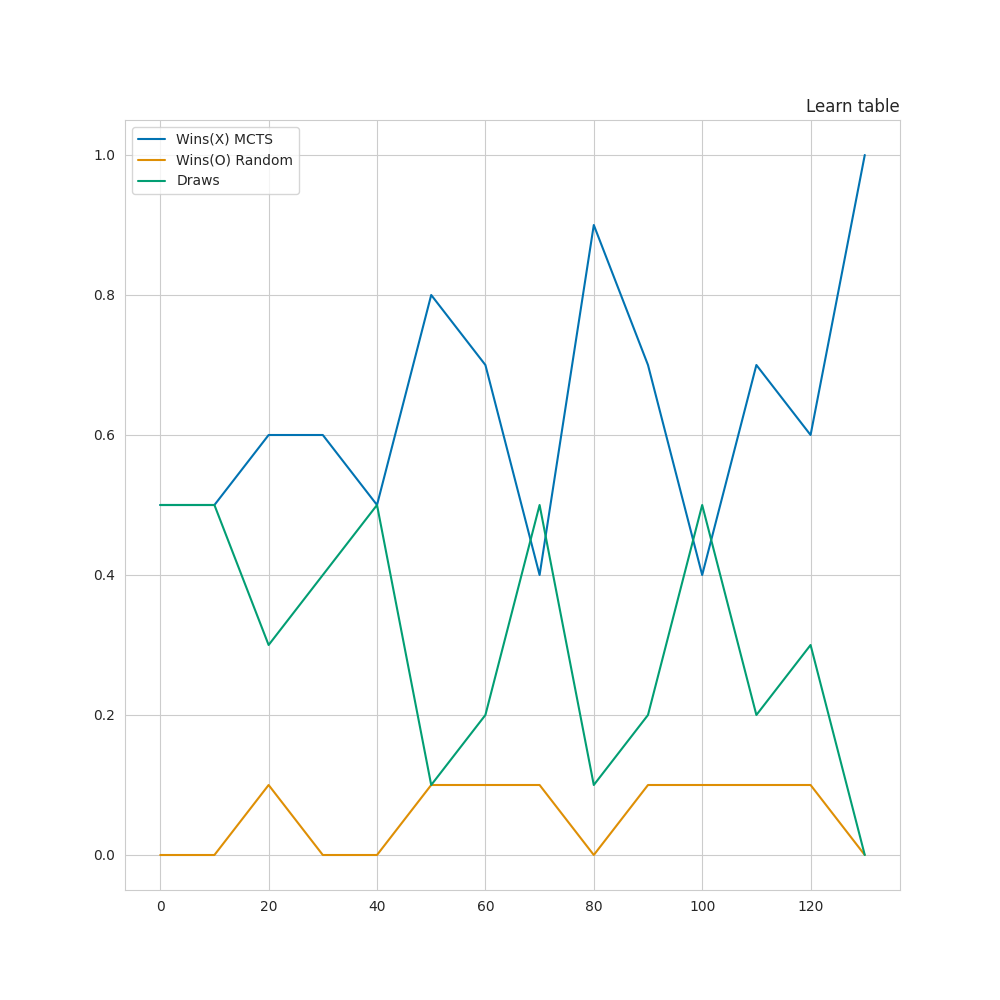

KeyboardInterrupt: 

In [109]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WINS)

dynamic_plot = DynamicPlot()
agent = MCTS()
num_tests = 100
num_games = 10
for iter_ in tqdm(range(num_tests)):
    wons_x, wons_o, draws = 0, 0, 0
    for _ in range(num_games):
        reward = play_game(env, agent, player=1)
        if reward == 1:
            wons_x += 1
        elif reward == -1:
            wons_o += 1
        else:
            draws += 1

    dynamic_plot.update('Learn table_Wins(X) MCTS', iter_ * num_games, wons_x / num_games) 
    dynamic_plot.update('Learn table_Wins(O) Random', iter_ * num_games, wons_o / num_games) 
    dynamic_plot.update('Learn table_Draws', iter_ * num_games, draws / num_games) 
    dynamic_plot.draw()


/home/gpu_user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<IPython.core.display.Javascript object>


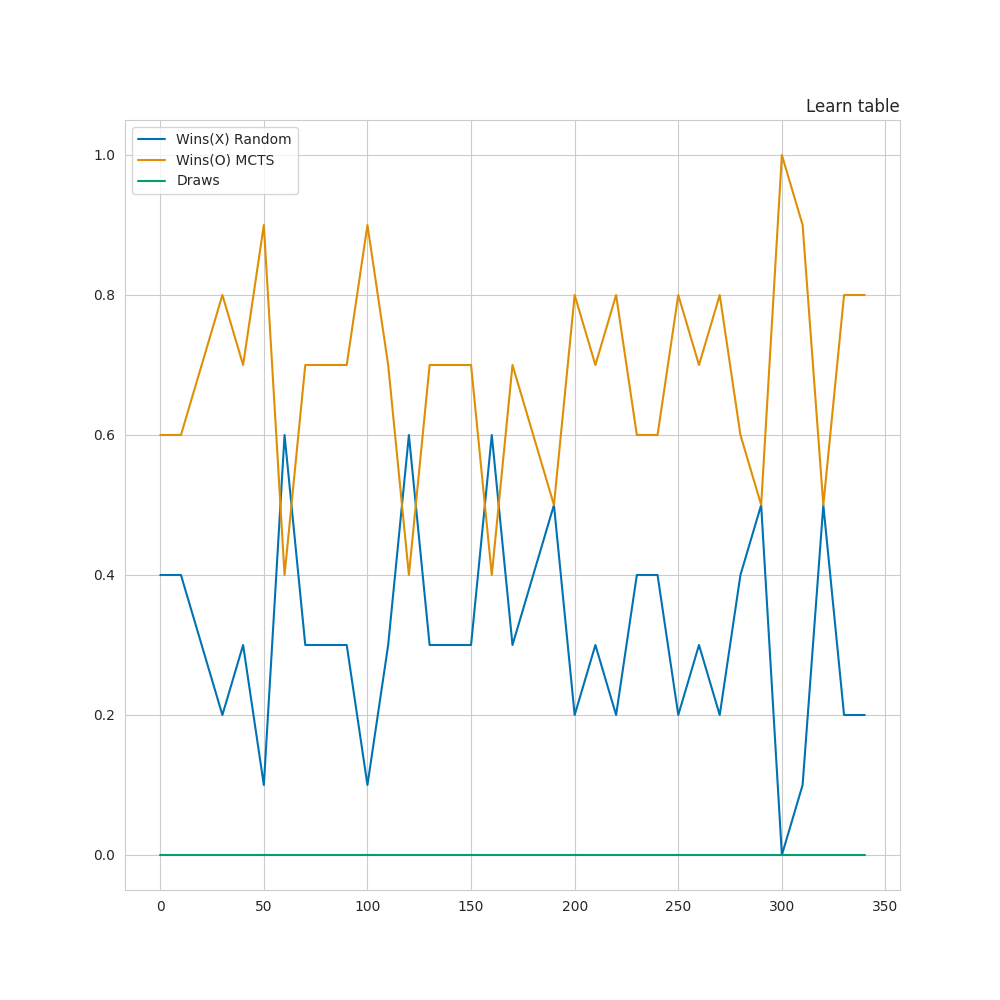

KeyboardInterrupt: 

In [110]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WINS)

dynamic_plot = DynamicPlot()
agent = MCTS()
num_tests = 100
num_games = 10
for iter_ in tqdm(range(num_tests)):
    wons_x, wons_o, draws = 0, 0, 0
    for _ in range(num_games):
        reward = play_game(env, agent, player=-1)
        if reward == 1:
            wons_x += 1
        elif reward == -1:
            wons_o += 1
        else:
            draws += 1

    dynamic_plot.update('Learn table_Wins(X) Random', iter_ * num_games, wons_x / num_games) 
    dynamic_plot.update('Learn table_Wins(O) MCTS', iter_ * num_games, wons_o / num_games) 
    dynamic_plot.update('Learn table_Draws', iter_ * num_games, draws / num_games) 
    dynamic_plot.draw()


## MCTS vs QTabular

In [113]:
def versus(env, agent_tree, opponent, player = 1):
    env.reset()
    state = TicTacToeNode(env.getState())
    while True:
        player_ = state.state[2]
        if player_ == player:
            for _ in range(50):
                agent.do_rollout(state)
            new_state = agent.choose(state)
        else:
            action = opponent.forward(state.state)
            new_state, _, _, _ = env.step(state.state[1][action])
            new_state = TicTacToeNode(new_state)
        if new_state.is_terminal():
            return new_state.reward()
            break
        state = new_state
    

<IPython.core.display.Javascript object>


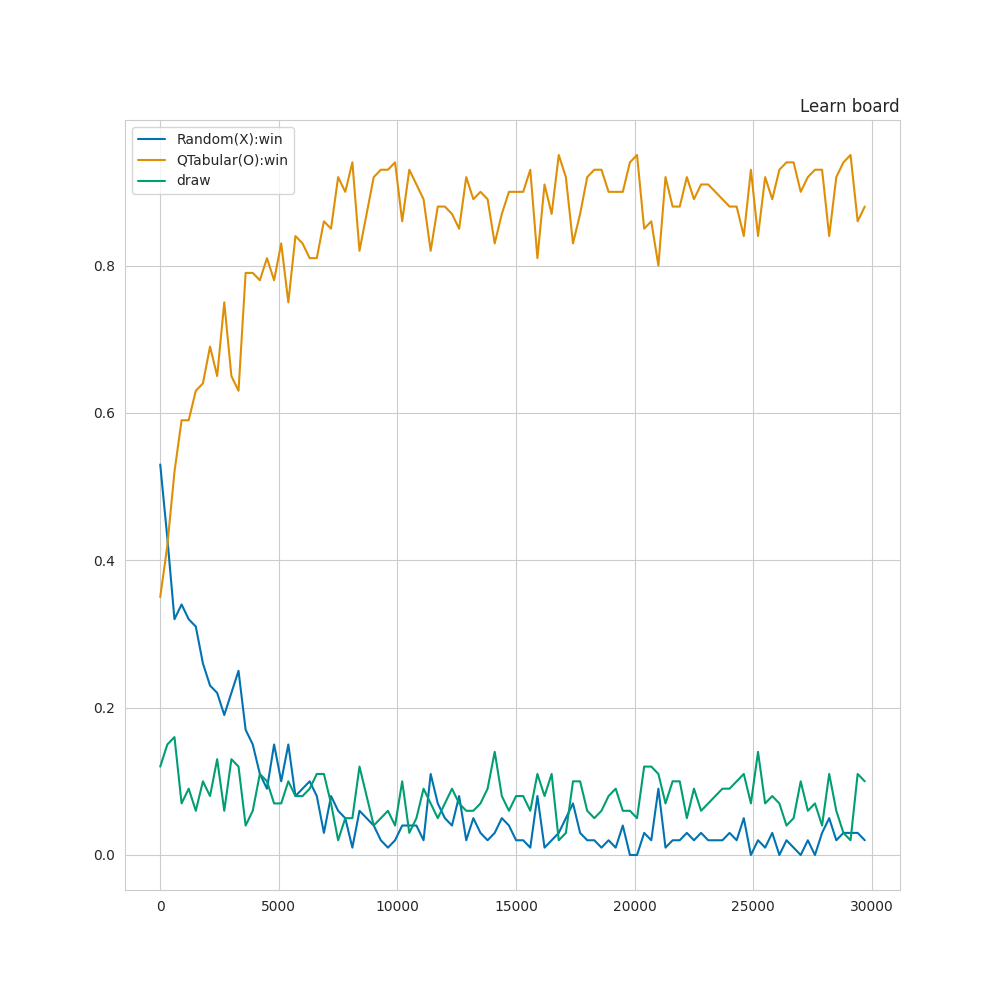

In [111]:
%matplotlib notebook

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

x_agent = RandomAgent(env)
o_agent = QTabularAgent(gamma=1, lr=0.01, epsilon=0.3)
train(env, x_agent, o_agent, num_episodes=30000)

/home/gpu_user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<IPython.core.display.Javascript object>


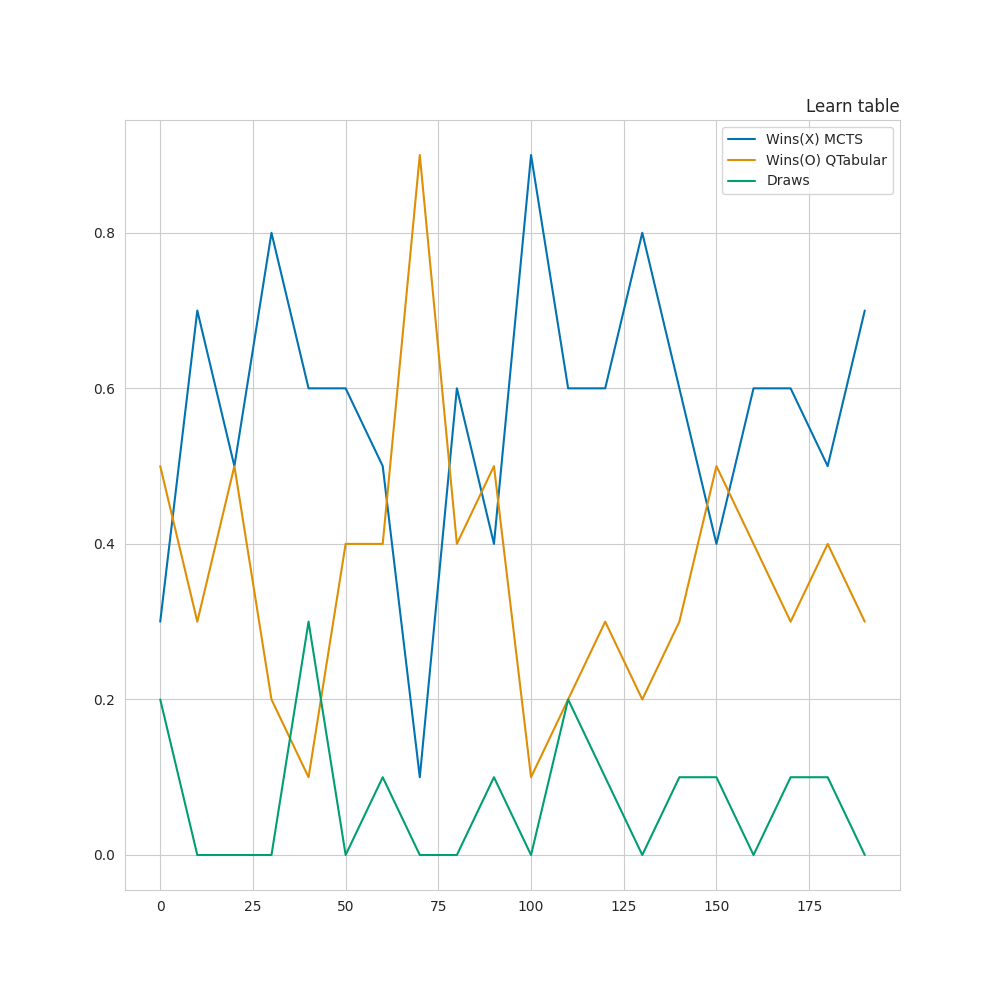

In [ ]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WINS)

dynamic_plot = DynamicPlot()
agent = MCTS()
opponent = o_agent
num_tests = 100
num_games = 10
for iter_ in tqdm(range(num_tests)):
    wons_x, wons_o, draws = 0, 0, 0
    for _ in range(num_games):
        reward = versus(env, agent, opponent, player=1)
        if reward == 1:
            wons_x += 1
        elif reward == -1:
            wons_o += 1
        else:
            draws += 1

    dynamic_plot.update('Learn table_Wins(X) MCTS', iter_ * num_games, wons_x / num_games) 
    dynamic_plot.update('Learn table_Wins(O) QTabular', iter_ * num_games, wons_o / num_games) 
    dynamic_plot.update('Learn table_Draws', iter_ * num_games, draws / num_games) 
    dynamic_plot.draw()


## P.S: Где-то накосячил с реализацией MCTS вплане эффективного кода и получил удручающую производительность... Однако, как видно метод работает 

## Кстати, стоит обратить внимание на класс DynamicPlot. Получился почти аналог тензорбоарда, но результат показывается в коде. Может когда-нибудь пригодится...